# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

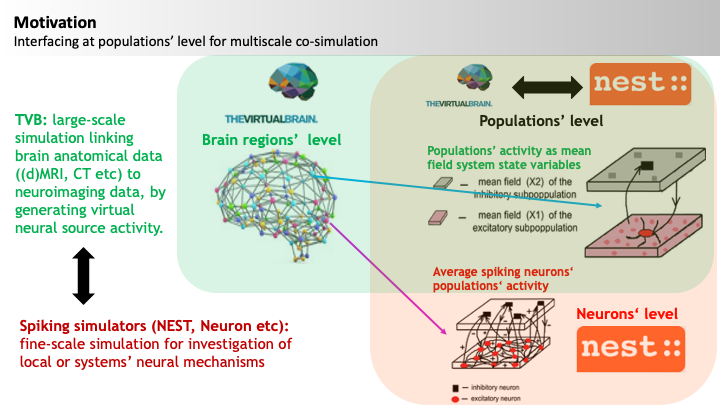

In [1]:
from IPython.core.display import Image, display
display(Image(filename='../pics/ConceptGraph1.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

## Reduced Wong-Wang TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}} = - \frac{1}{\tau}{S_{n\prime}}(t) + (1-{S_{n\prime}}(t))\gamma {R_{n\prime}}(t)$

and $ {R_{n\prime}}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}(t) = H({I_{syn_{n\prime}}}(t), a, b, d) $

where

$ H({I_{syn_{n\prime}}}(t),  a, b, d) = \frac{aI_{syn_{n\prime}}(t)-b}{1-e^{-d(a{I_{syn_{n\prime}}}(t)-b)}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}(t) = I_o + w_+J_{N}{S_{n\prime}}(t) + GJ_{N}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}(t-\tau_{{m\prime}{n\prime}})$

## Reduced Wong-Wang mean field model

### Parameters following Deco et al 2013:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.3nA$ 
- excitatory synaptic coupling $J_{N} = 0.2609nA$ 
- local excitatory recurrence $w_+ = 0.9$
- excitatory kinetic parameter $\gamma = 0.641 s$
- excitatory sigmoidal functions parameters $a = 2710nC^{-1}$, $b = 108Hz$, $d = 0.154s$


## Izhikevich Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in NEST as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C - g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e$

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



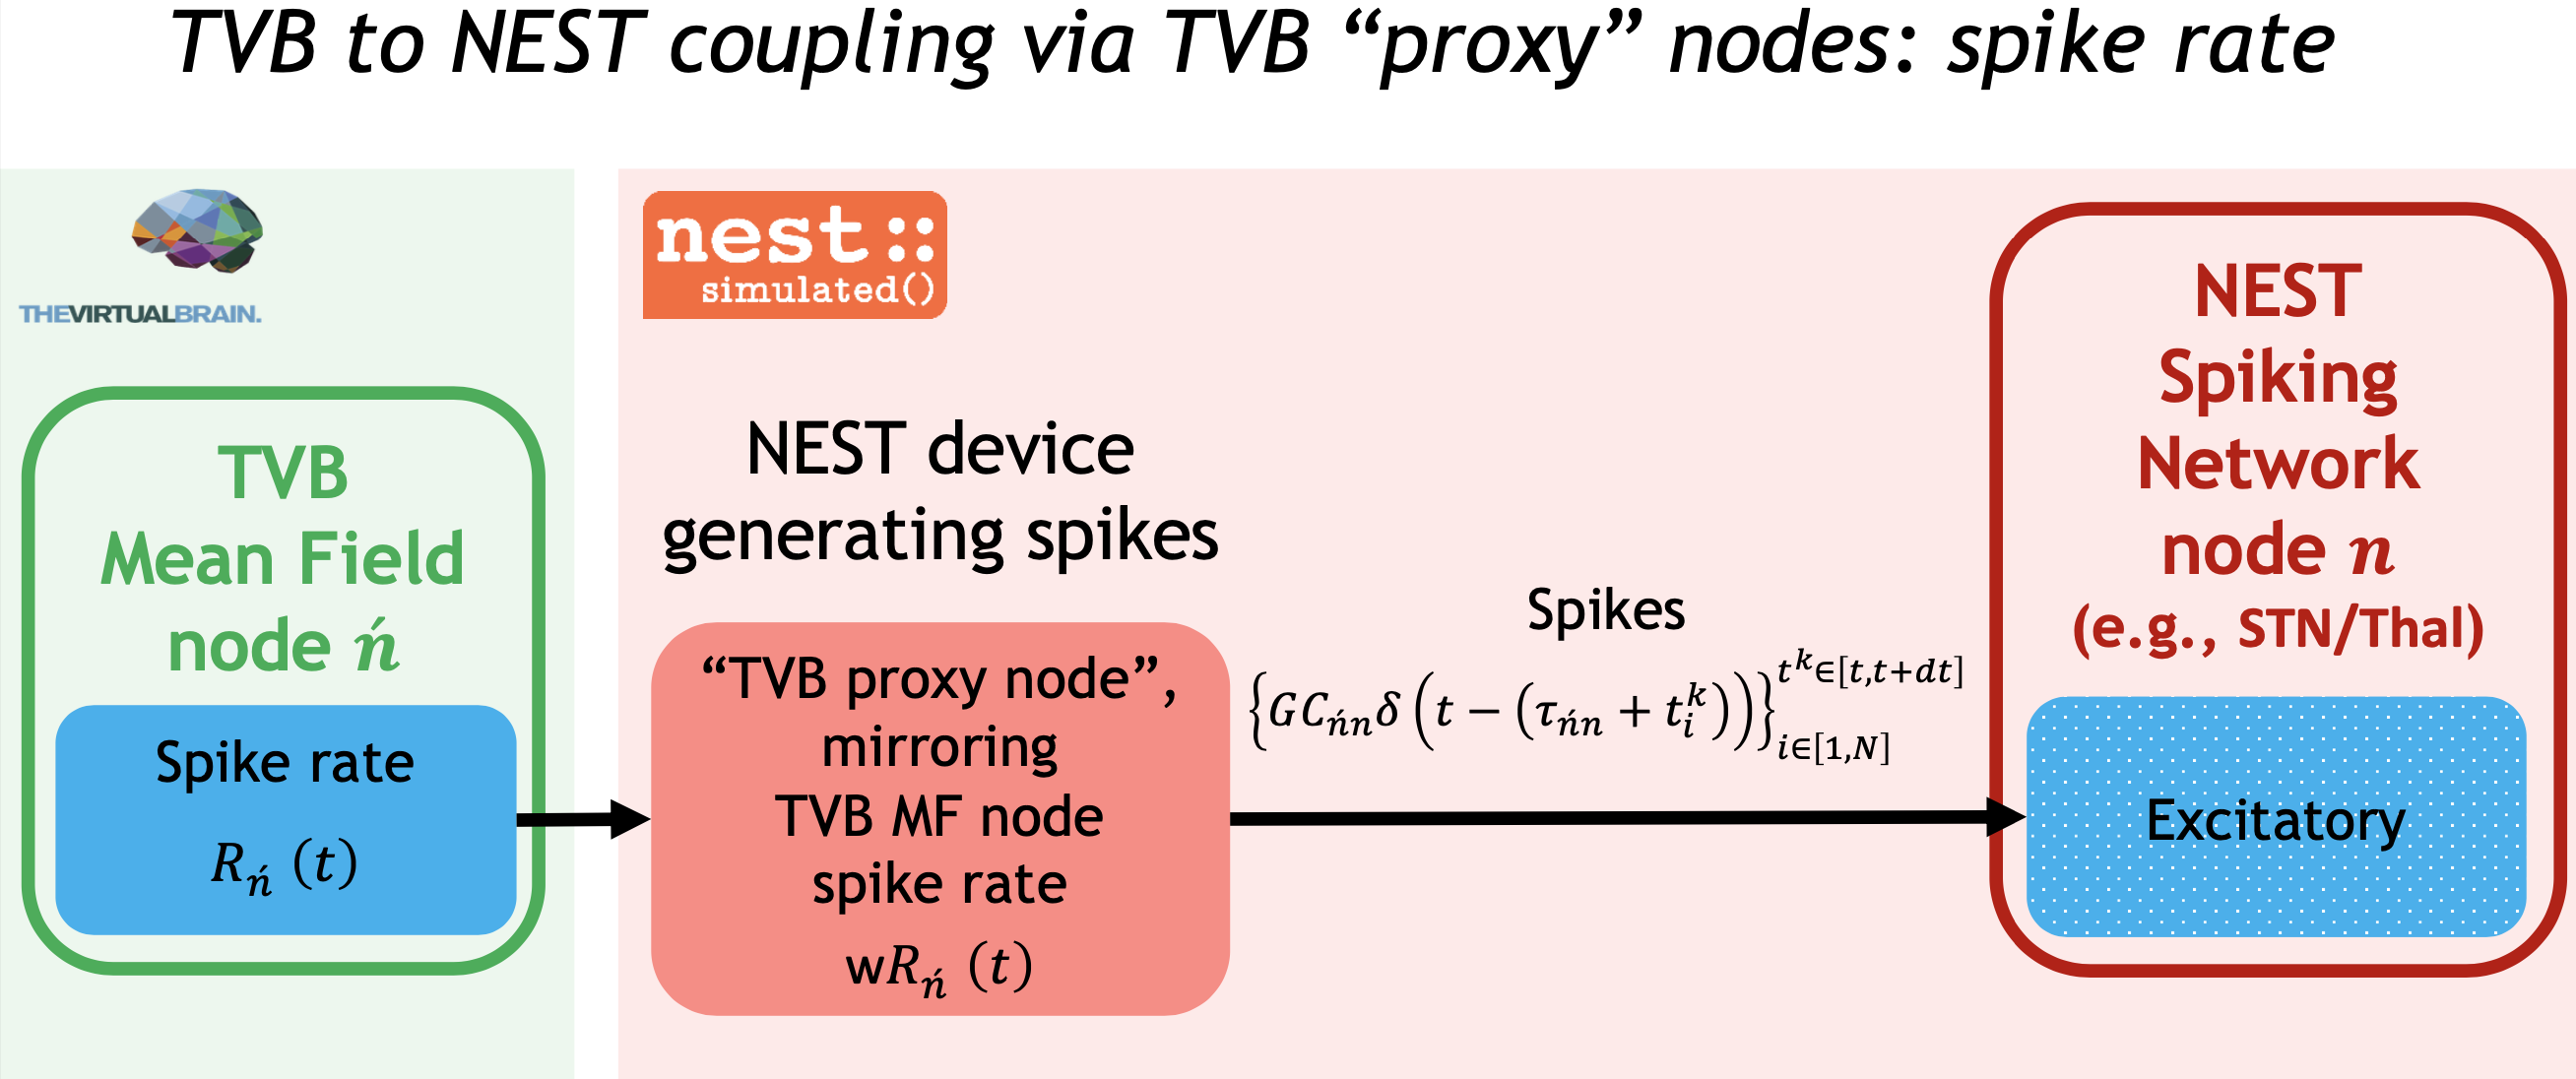

In [2]:
display(Image(filename='../pics/Rate_BG.png',  width=1000, unconfined=False))

## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides an auxiliary TVB state variables $R_{in}(t)$, which drives a linear integration equation of another auxiliary TVB state variable $R_{int}(t)$, which,in its turn, acts as a smoothing low pass filter:

$ \dot{R}_{int_{n}}  = -\frac{1}{\tau_{rin_{n}}}(R_{int_{n}}(t) - {R_{in_{n}}}(t)) $


where:

$ {R_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

Finally, $ {R_{int_{n}}}(t) $ overwrites the variable ${R_{n}}(t)$ via a user defined transform function:

${R_{n}}(t) = f_{NEST->TVB}({R_{int_{n}}}(t)) $

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


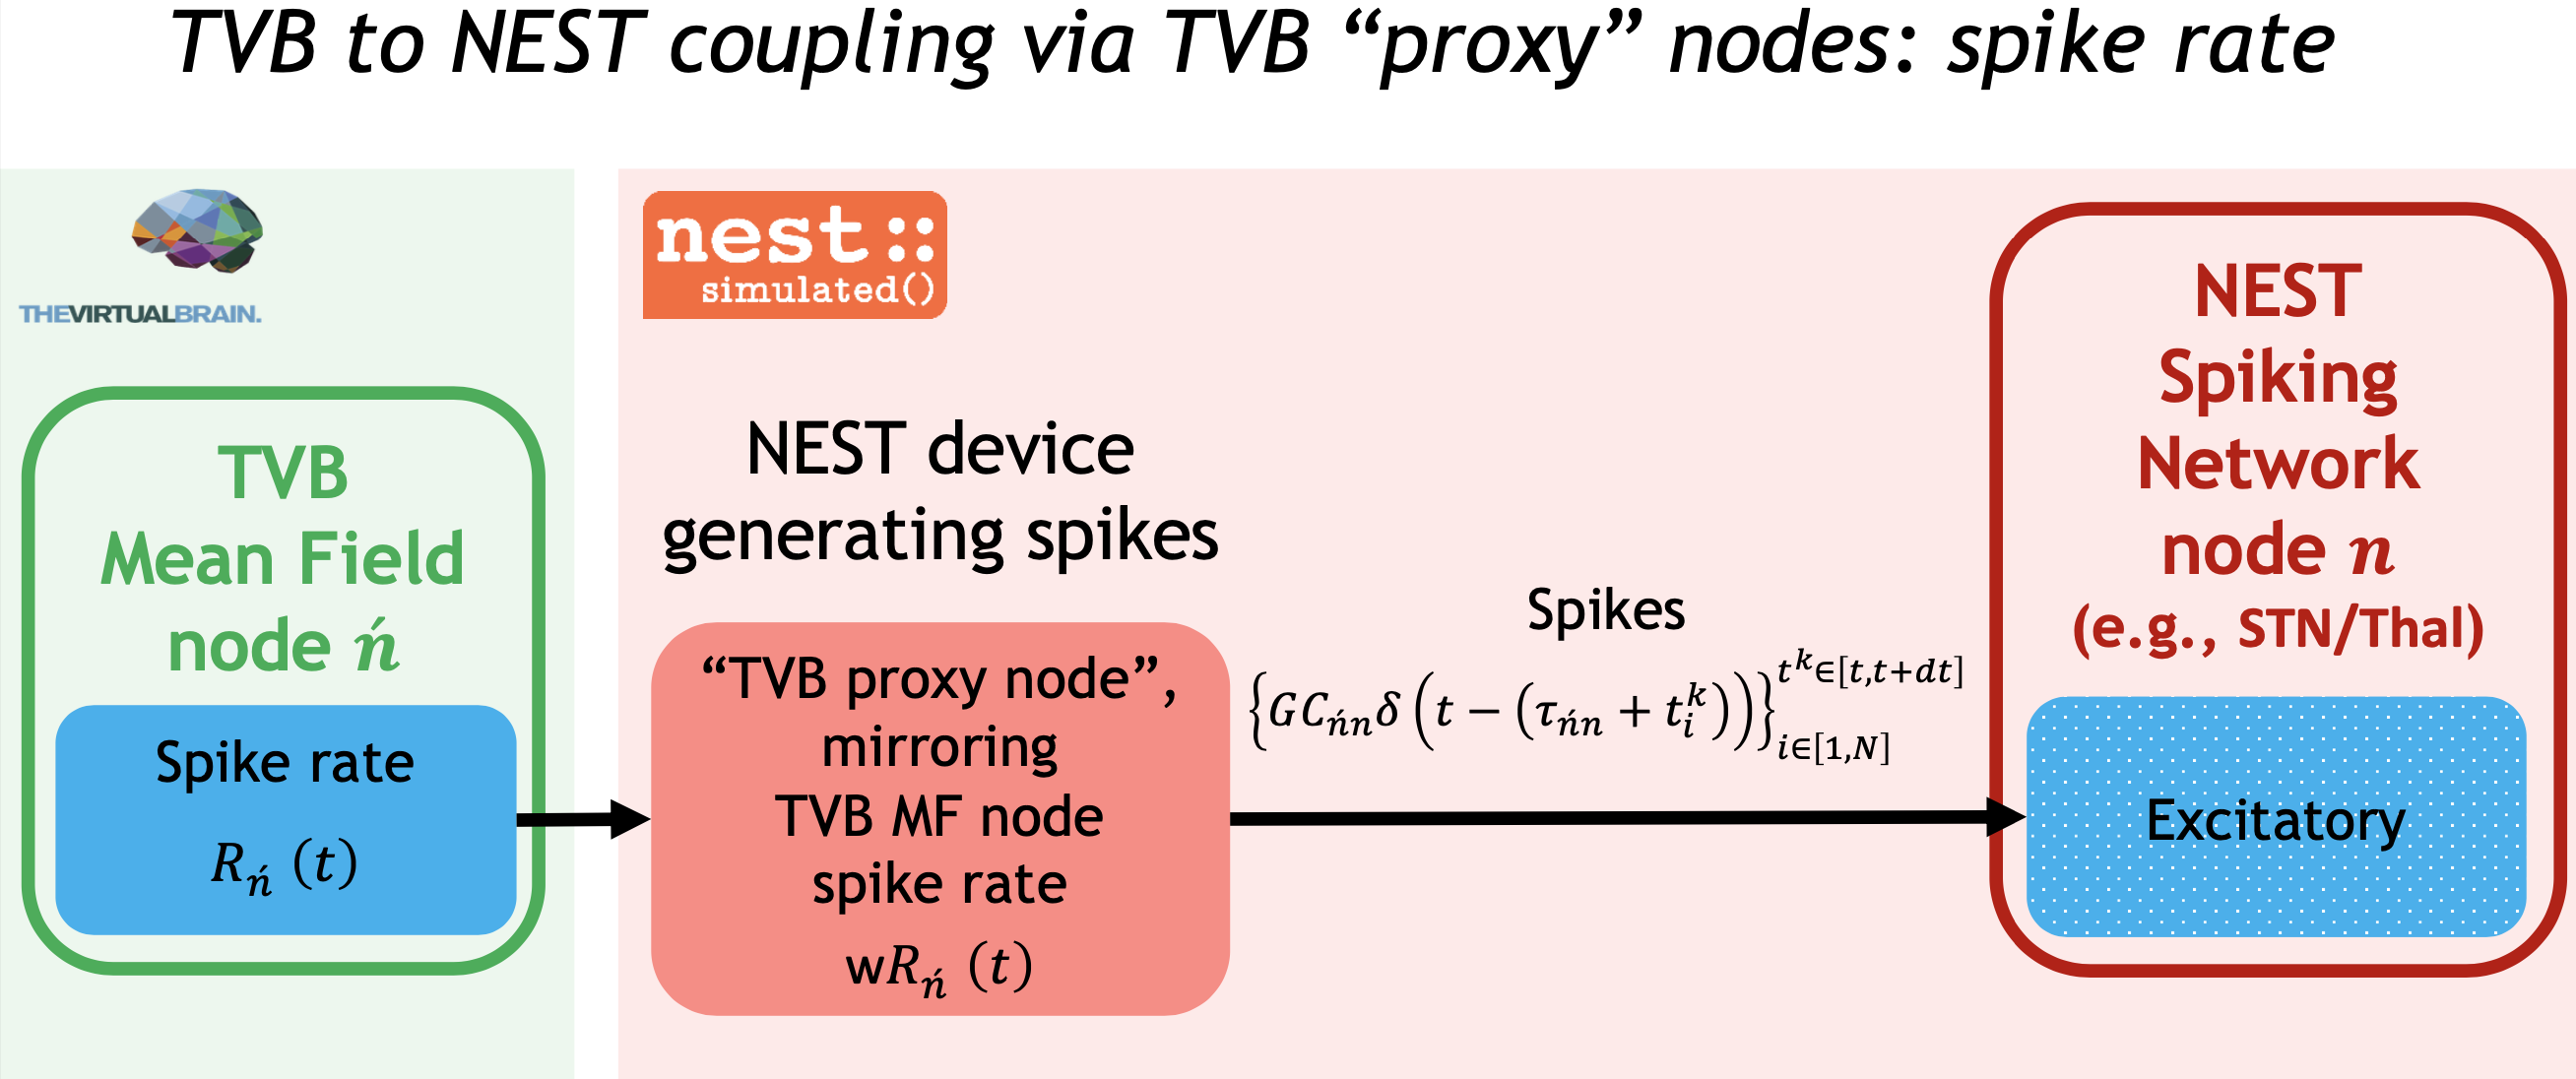

In [3]:
display(Image(filename='../pics/Rate_BG.png',  width=1000, unconfined=False))

# WORKFLOW:

In [4]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.replace("tvb_nest", "tvb_annarchy").split("tvb_annarchy")[0], "data")
fit_data_path = os.path.join(data_path, "ANNarchyFittedModels/dataFits_2020_02_05/databestfits", )
data_mode = "patient" # "control", "patient"
control_data = os.path.join(fit_data_path, "controlleft/OutputSim_Patient08.mat")
patient_data = os.path.join(fit_data_path, "patientleft/OutputSim_Patient09.mat")
if data_mode == "patient":
    subject_data = patient_data
    global_coupling_scaling = 0.3
    dSN_factor = 0.6 # p5: 0.7, p10: 0.65, p9: 0.6
    iSN_factor = 0.6 # p5: 0.5,  p10: 0.55, p9: 0.6
else:
    subject_data = control_data
    global_coupling_scaling = 0.3
    dSN_factor = 0.55
    iSN_factor = 0.55
    
simulation_length = 150.0
transient = 50.0
start_stimulus = 40.0
init_cond_jitter = 0.0

simulation_mode = "rs" # "stim" # "rs"
stim_target = "GPi"    #    "STN",         "GPi"
stim_mode = "simple"       # "bi"  | "mono" | "simple"
                       # -------------------------
stim_freq = 000.0      # 130.0 |  120.0 |    0.0 
stim_ampl = -10.0      #  20.0 |  -35.0 |  -10.0 
stim_duration = 0.0    #   0.3 |    0.3 |    0.0
if simulation_mode == "stim":
    simulation_mode = simulation_mode + "_%s_%s" % (stim_target, stim_mode)

outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich")
sim_mode_path = os.path.join(outputs_path, "TVBcortex", data_mode, simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-04-27 17:34:01,965 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-04-27 17:34:01,965 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-04-27 17:34:01,968 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-04-27 17:34:01,968 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-04-27 17:34:01,972 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-04-27 17:34:01,972 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-04-27 17:34:01,977 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-04-27 17:34:01,977 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-04-27 17:34:01,982 - INFO - tvb_multiscale.tv

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [5]:
from tvb_multiscale.core.tvb.cosimulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    

# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))
conn_mode = "subject" # "average"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
    weights=sio.loadmat(subject_data)    # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19]   # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
pCtxItoI = probs_maith[18] # "CxI" -> "CxI"
pCtxCtx = probs_maith[16:19].mean() # "Ctx" -> "Ctx"

loadedParams ={'dSNGPi_probs': probs_maith[0],
    	'dSNGPi_weights'  : weights_maith[0],
    	'iSNGPe_probs'   : probs_maith[1],
    	'iSNGPe_weights'  : weights_maith[1],
    	'GPeSTN_probs'   : probs_maith[2],
    	'GPeSTN_weights'  : weights_maith[2],
    	'STNGPe_probs'   : probs_maith[3],
    	'STNGPe_weights'  : weights_maith[3],
    	'STNGPi_probs'   : probs_maith[4],
    	'STNGPi_weights' : weights_maith[4],
    	'GPeGPi_probs'   : probs_maith[5],
    	'GPeGPi_weights'  : weights_maith[5],
    	'GPeGPe_probs'   : probs_maith[6],
    	'GPeGPe_weights'  : weights_maith[6],
    	'GPiGPi_probs'   : probs_maith[7],
    	'GPiGPi_weights'  : weights_maith[7],
    	'GPiThal_probs'   : probs_maith[8],
    	'GPiThal_weights'  : weights_maith[8],
    	'ThaliSN_probs'   : probs_maith[9],
    	'ThaliSN_weights'  : weights_maith[9],
    	'ThaldSN_probs'   : probs_maith[10],
    	'ThaldSN_weights'  : weights_maith[10],
    	'dSNdSN_probs'   : probs_maith[11],
    	'dSNdSN_weights'  : weights_maith[11],
    	'iSNiSN_probs'   : probs_maith[12],
    	'iSNiSN_weights'  : weights_maith[12],
    	'CtxdSN_probs'   : probs_maith[13],
    	'CtxdSN_weights'  : weights_maith[13],
    	'CtxiSN_probs'   : probs_maith[14],
    	'CtxiSN_weights'  : weights_maith[14],
    	'CtxSTN_probs'   : probs_maith[15],
    	'CtxSTN_weights'  : weights_maith[15],
    	'CtxECtxI_probs'    : probs_maith[16],
    	'CtxECtxI_weights'  : weights_maith[16],
    	'CtxICtxE_probs'    : probs_maith[17],
    	'CtxICtxE_weights'  : weights_maith[17],
    	'CtxICtxI_probs'   : probs_maith[18],
    	'CtxICtxI_weights'  : weights_maith[18],
        'CtxThal_weights': 0.0,
        'CtxThal_probs': 1.0}
print(loadedParams)

assert_loadedParams = dict(zip(loadedParams.values(), loadedParams.keys()))

{'dSNGPi_probs': 0.17859516634489409, 'dSNGPi_weights': 0.008694033162319101, 'iSNGPe_probs': 0.33518908071564507, 'iSNGPe_weights': 0.008090356577449711, 'GPeSTN_probs': 0.16505628454033283, 'GPeSTN_weights': 0.005997084264236037, 'STNGPe_probs': 0.3962228806747589, 'STNGPe_weights': 0.011259651579748606, 'STNGPi_probs': 0.24895916907698845, 'STNGPi_weights': 0.012728955057755228, 'GPeGPi_probs': 0.3252567500370787, 'GPeGPi_weights': 0.006170218545084936, 'GPeGPe_probs': 0.32325378120003734, 'GPeGPe_weights': 0.006765628813882359, 'GPiGPi_probs': 0.3371743973897537, 'GPiGPi_weights': 0.01216071144597663, 'GPiThal_probs': 0.24578932343574705, 'GPiThal_weights': 0.007014219544362278, 'ThaliSN_probs': 0.13343960522906853, 'ThaliSN_weights': 0.005992356203860255, 'ThaldSN_probs': 0.12055055752571203, 'ThaldSN_weights': 0.012069912539882353, 'dSNdSN_probs': 0.43455099617713133, 'dSNdSN_weights': 0.007630499957085704, 'iSNiSN_probs': 0.22354489027929958, 'iSNiSN_weights': 0.0141184567240998

Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:
 [[   0.    0. 2642.    0.  781.    0.  200.    0.]
 [   0.    0.    0. 1034.    0.   45.    0. 1025.]
 [2642.    0.    0.    0. 6058.    0. 1337.    0.]
 [   0. 1034.    0.    0.    0.  162.    0.  381.]
 [ 781.    0. 6058.    0.    0.    0. 1026.    0.]
 [   0.   45.    0.  162.    0.    0.    0.  989.]
 [ 200.    0. 1337.    0. 1026.    0.    0.    0.]
 [   0. 1025.    0.  381.    0.  989.    0.    0.]]
Removing BG -> Cortex connections with max:
1931.34115274226
Removing Cortex -> Thalamus connections with summed weight:
7385.840310132234
Removing BG <- Cortex connections with max:
1682.84151027352

Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:


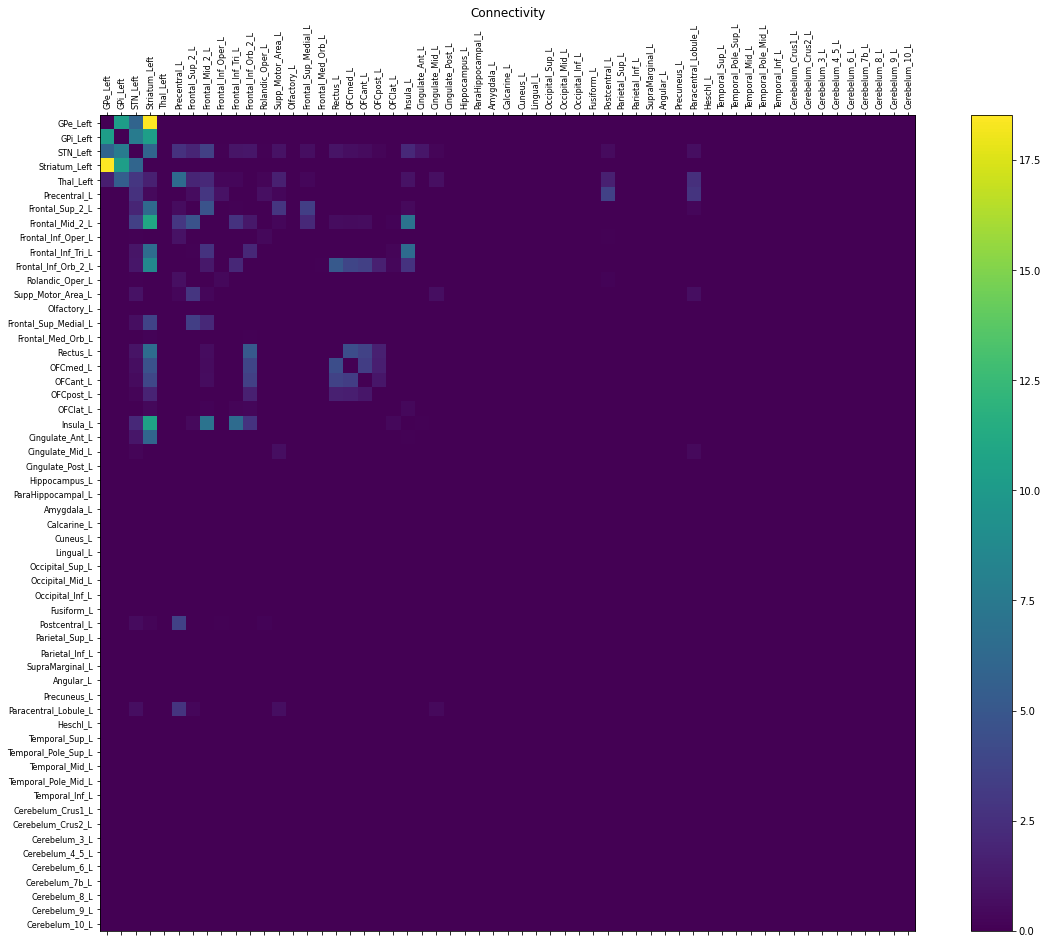

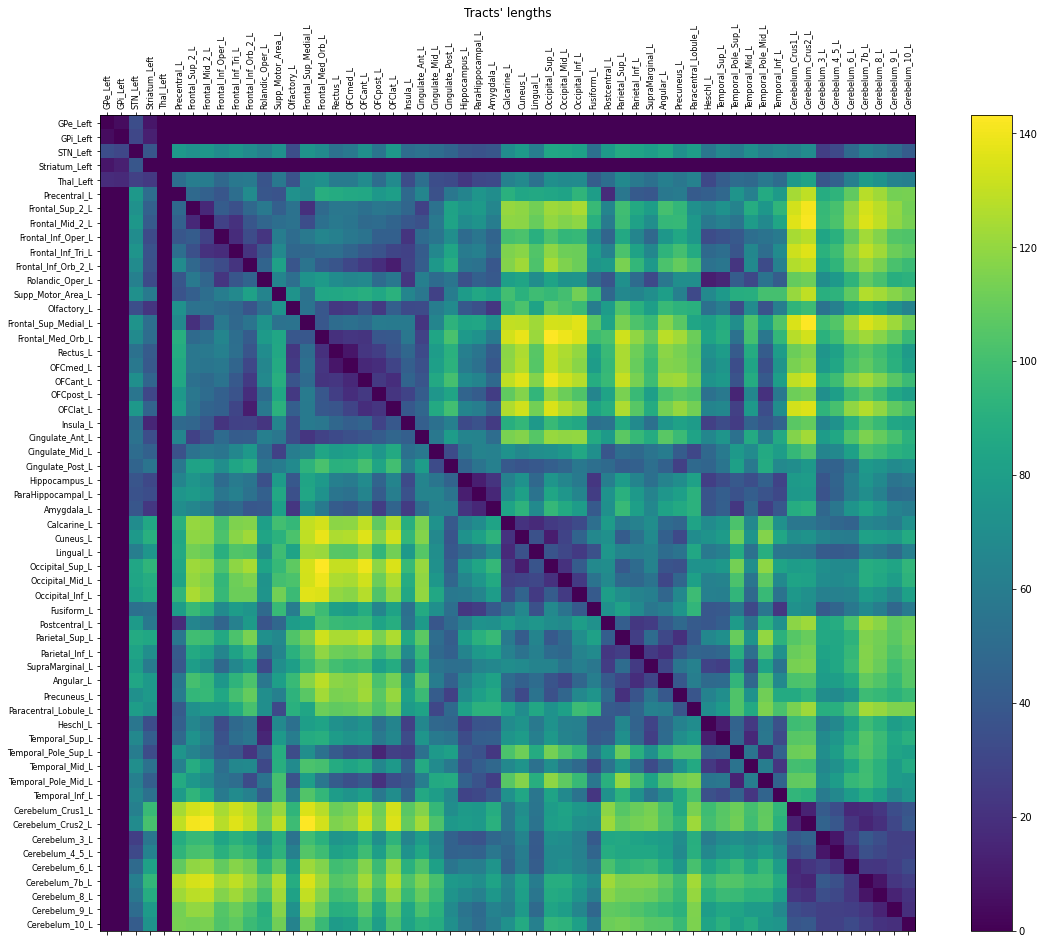

In [6]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,4))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# Remove the second Thalamus, Pallidum (GPe/i), Putamen and Caudate (Striatum):
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
inds_Pall = (rlTVB.tolist().index("Pallidum_L"), rlTVB.tolist().index("Pallidum_R"))
inds_Put = (rlTVB.tolist().index("Putamen_L"), rlTVB.tolist().index("Putamen_R"))
inds_Caud = (rlTVB.tolist().index("Caudate_L"), rlTVB.tolist().index("Caudate_R"))
inds_rm = inds_Th + inds_Pall + inds_Put + inds_Caud
print("Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:\n", 
      wTVB[inds_rm, :][:, inds_rm])
wTVB = np.delete(wTVB, inds_rm, axis=0)
wTVB = np.delete(wTVB, inds_rm, axis=1)
tlTVB = np.delete(tlTVB, inds_rm, axis=0)
tlTVB = np.delete(tlTVB, inds_rm, axis=1)
rlTVB = np.delete(rlTVB, inds_rm, axis=0)
cTVB = np.delete(cTVB, inds_rm, axis=0)

number_of_regions = len(rlTVB)
speed = np.array([4.0])
min_tt = speed.item() * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove Cortex -> Thalamus connections
sliceThal = [8, 9]
print("Removing Cortex -> Thalamus connections with summed weight:")
print(wTVB[:, 4].sum())
wTVB[:, sliceThal] = 0.0
tlTVB[:, sliceThal] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB, speed=speed)

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connLeft = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                        centres=connTVB.centres[sliceLeft],
                        weights=connTVB.weights[sliceLeft][:, sliceLeft],
                        tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft], 
                       speed=connTVB.speed)
connLeft.configure()

print("\nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:")
plotter.plot_tvb_connectivity(connLeft);



Left BG TVB network:


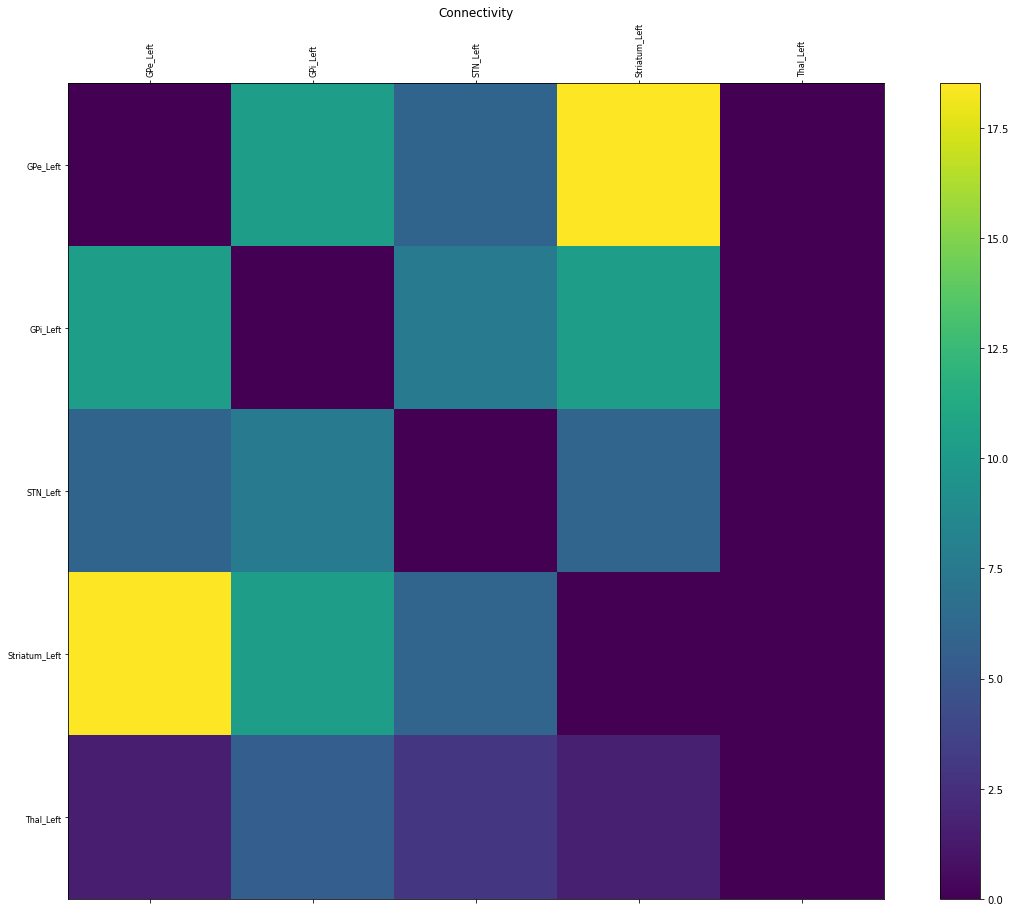

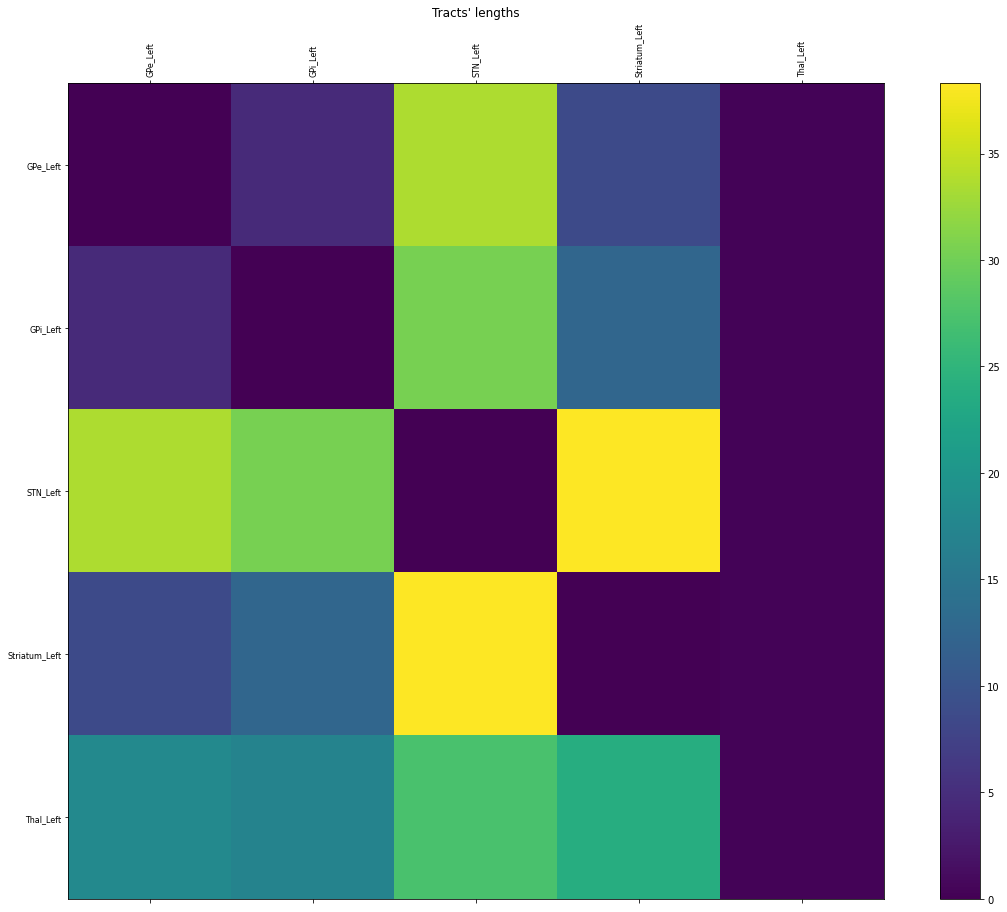

In [7]:
sliceBGnet = slice(0,5)
connTVBleftBG = Connectivity(region_labels=connLeft.region_labels[sliceBGnet], 
                             centres=connLeft.centres[sliceBGnet],
                             weights=connLeft.weights[sliceBGnet][:, sliceBGnet],
                             tract_lengths=connLeft.tract_lengths[sliceBGnet][:, sliceBGnet], 
                            speed=connLeft.speed)
connTVBleftBG.configure()

print("\nLeft BG TVB network:")
plotter.plot_tvb_connectivity(connTVBleftBG);

In [8]:
scaleBGoptTOtvb = np.percentile(BG_opt_matrix_weights, 95) /\
                  np.percentile(connTVBleftBG.weights, 95)
                  
print("Scaling factor of TVB BG network connectome to optimal one = %g" % scaleBGoptTOtvb)


Scaling factor of TVB BG network connectome to optimal one = 0.000705308



Left BG optimized network:


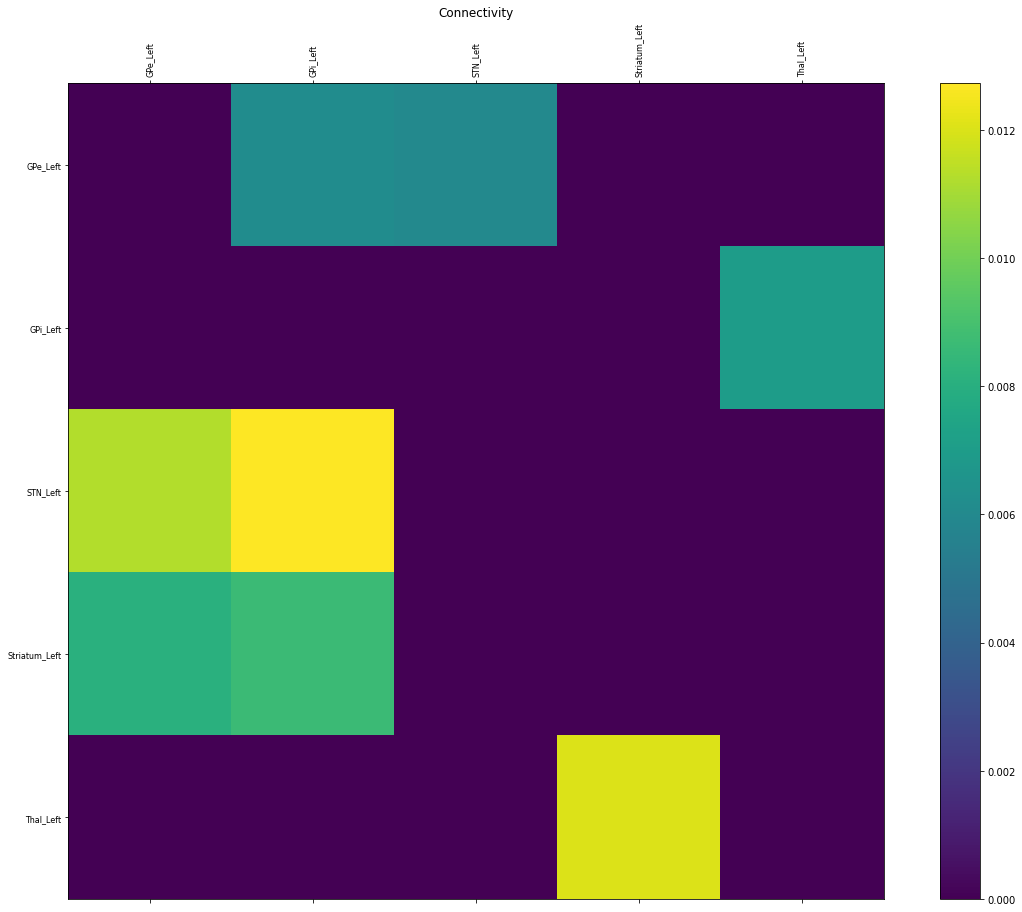

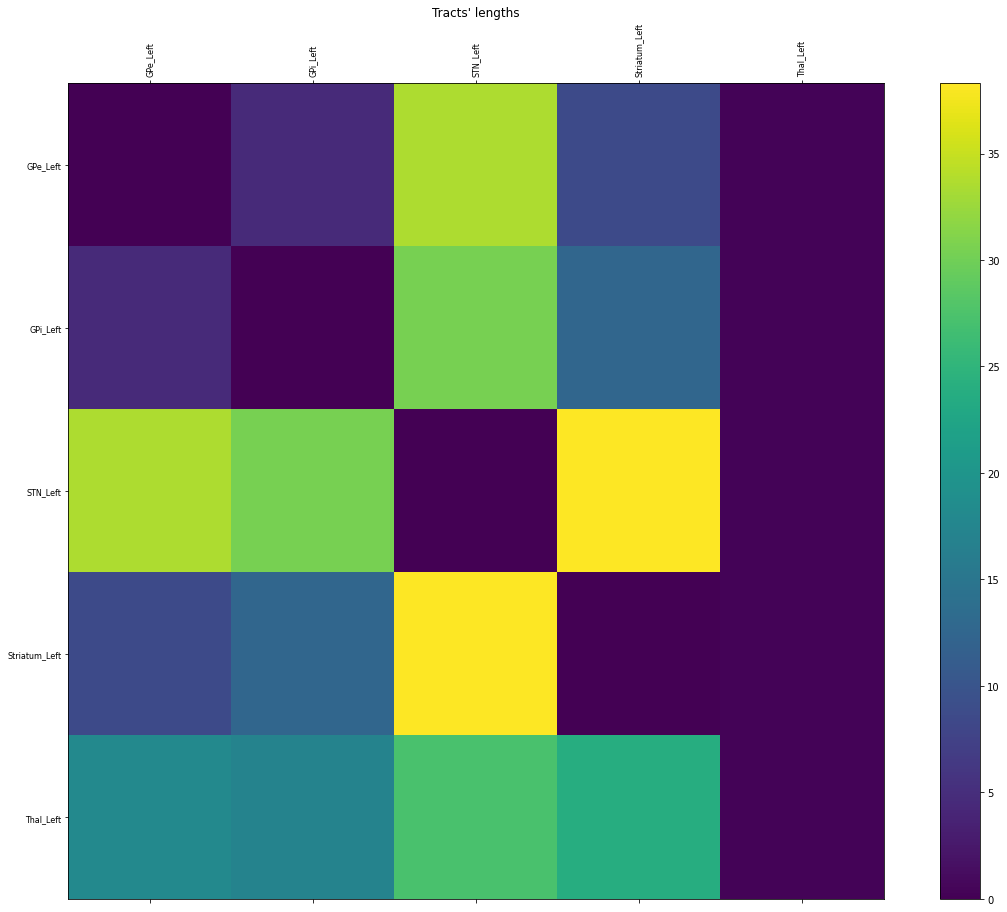

In [9]:
# Construct the final connectivity to use for simulation:
ww = scaleBGoptTOtvb * np.array(connLeft.weights)
ww[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

connectivity = Connectivity(region_labels=connLeft.region_labels, 
                            centres=connLeft.centres,
                            weights=ww, tract_lengths=connLeft.tract_lengths, 
                            speed=connLeft.speed)
connectivity.configure()

# Construct only the optimized BG connectivity only for plotting:
connBGopt = Connectivity(region_labels=connectivity.region_labels[sliceBGnet], 
                         centres=connectivity.centres[sliceBGnet],
                         weights=connectivity.weights[sliceBGnet][:, sliceBGnet],
                         tract_lengths=connectivity.tract_lengths[sliceBGnet][:, sliceBGnet], 
                         speed=connectivity.speed)
connBGopt.configure()

print("\nLeft BG optimized network:")
plotter.plot_tvb_connectivity(connBGopt);


Connectome used for simulations:


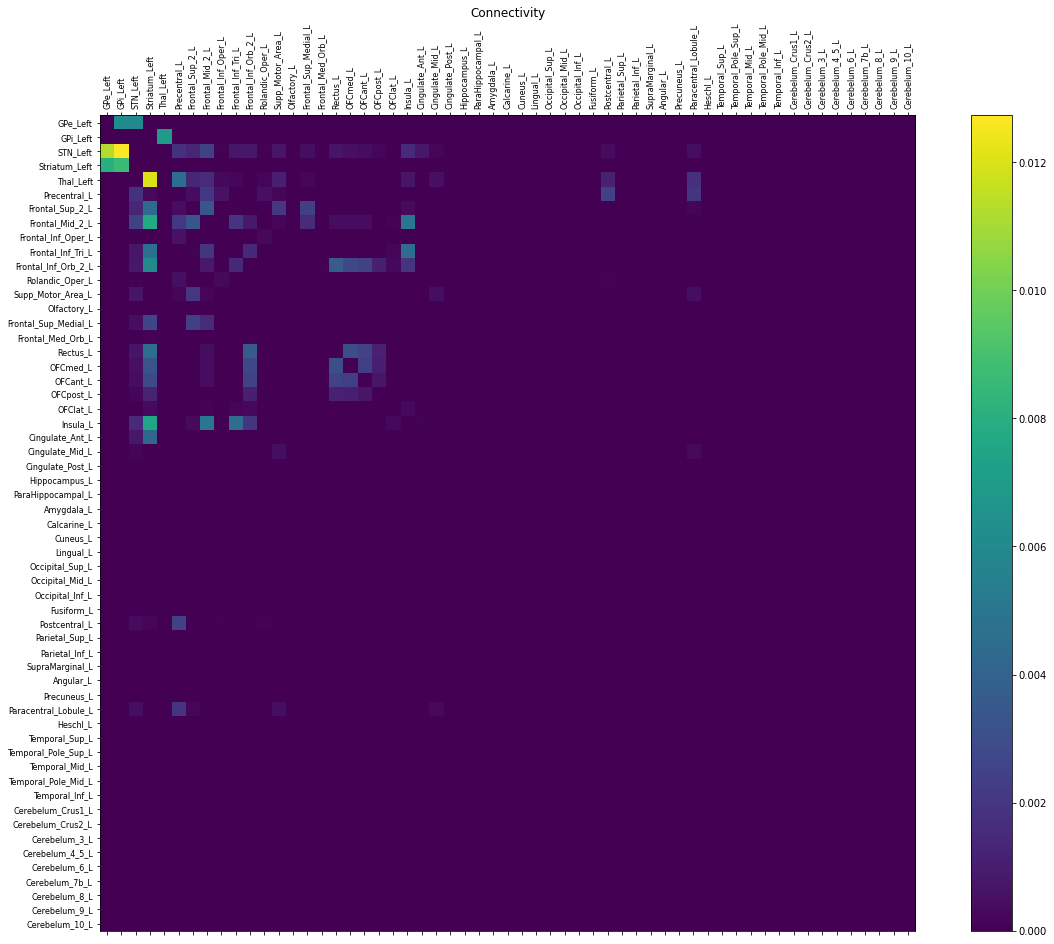

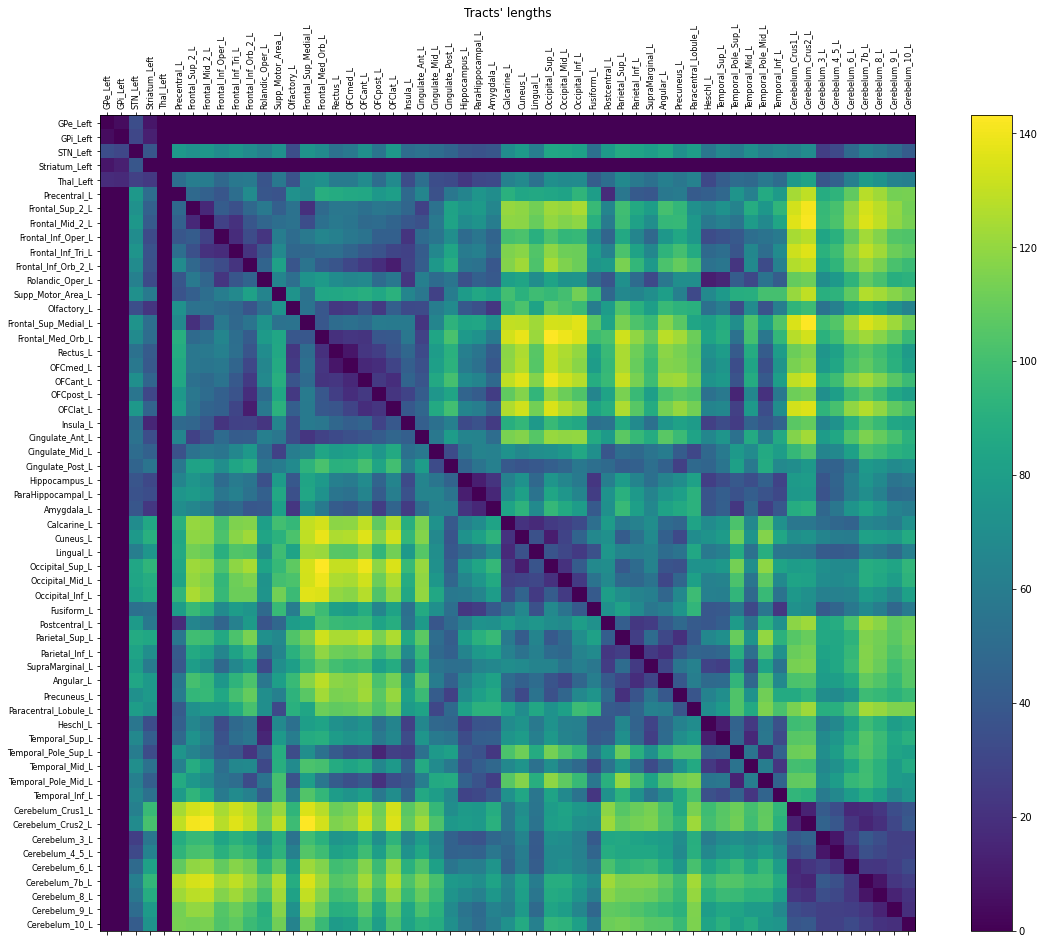

In [10]:
#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {"G": np.array([15.0/scaleBGoptTOtvb])}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-4])  # 1e-5

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond_filepath = os.path.join(outputs_path, "tvb_init_cond_left.npy")
init_cond = np.load(init_cond_filepath)   # 
init_cond = np.abs(init_cond *(1 + init_cond_jitter * np.random.normal(size=init_cond.shape)))
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations:")
plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [11]:
from tvb_multiscale.tvb_nest.nest_models.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder

# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
#including cortex node:
nest_nodes_ids = [0, 1, 2, 3, 4]  #, 5 the indices of fine scale regions modeled with NEST

# Build a NEST network model with the corresponding builder
nest_model_builder = BasalGangliaIzhikevichBuilder(simulator, nest_nodes_ids, config=config)
nest_model_builder.configure()


# Using all default parameters for this example
# nest_model_builder.set_defaults()

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = "izhikevich_hamker"

nest_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

nest_model_builder.params_common = \
    {"V_m": -72.0, "U_m": -14.0, "E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "V_r": 0.0, "c": -65.0,
     "C_m": 1.0, "I_e": 0.0, "current_stimulus_scale": 1.0, "current_stimulus_mode": 0,
     "tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

nest_model_builder._paramsI = deepcopy(nest_model_builder.params_common)
nest_model_builder._paramsI.update({"V_m": -70.0, "U_m": -18.55, 
                                    "a": 0.005, "b": 0.585, "d": 4.0})
nest_model_builder._paramsE = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr.update({"V_m": -70.0, "U_m": -18.55, 
                                     "V_th": 40.0, "C_m": 50.0, "V_r": -80.0,
                                     "n0": 61.65119, "n1": 2.594639, "n2": 0.022799,
                                     "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

nest_model_builder.Igpe_nodes_ids = [0]
nest_model_builder.Igpi_nodes_ids = [1]
nest_model_builder.Estn_nodes_ids = [2]
nest_model_builder.Eth_nodes_ids = [4]
nest_model_builder.Istr_nodes_ids = [3]

I_nodes_ids = nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids 
E_nodes_ids = nest_model_builder.Estn_nodes_ids + nest_model_builder.Eth_nodes_ids 


def paramsE_fun(node_id):
    paramsE = deepcopy(nest_model_builder._paramsE)
    if node_id in nest_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I_e": 3.0})  # dictionary of params for Estn
    elif node_id in nest_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I_e": 3.5}) # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(nest_model_builder._paramsI)
    if node_id in nest_model_builder.Igpe_nodes_ids:
        paramsI.update({"I_e": 12.0})  # 12.0
    elif node_id in nest_model_builder.Igpi_nodes_ids:
        paramsI.update({"I_e": 30.0})  # 30.0
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
nest_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0}, 
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0}, 
    {"label": "IdSN", "model": population_neuron_model,   
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]


# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
# nest_model_builder.global_coupling_scaling = nest_model_builder.tvb_simulator.coupling.a[0].item() 
nest_model_builder.global_coupling_scaling = 1.0 # nest_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# nest_model_builder.global_coupling_scaling *= nest_model_builder.tvb_simulator.model.G[0].item()


# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "static_synapse"
conn_spec = {"allow_autapses": True, "allow_multapses": True, 'rule': "all_to_all",
             "indegree": None, "outdegree": None, "N": None, "p": 0.1}

conn_spec_bernoulli = conn_spec.copy()
conn_spec_bernoulli.update({'rule': "pairwise_bernoulli", "p": 0.1})

def conn_spec_prob(prob=None):
    output = conn_spec_bernoulli.copy()
    if prob is not None:
        output["p"] = prob
    return output

within_node_delay = 1.0

# for each connection, we have a different probability
nest_model_builder.populations_connections = [
# #      #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeGPe),
     "weight": -np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Igpe_nodes_ids,
    },  # None means apply to all
     {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPiGPi),
     "weight": -np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Igpi_nodes_ids,
    },  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "model": synapse_model, "conn_spec": conn_spec_prob(pdSNdSN),
     "weight": -np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "model": synapse_model, "conn_spec": conn_spec_prob(piSNiSN),
     "weight": -np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    ]



# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

        
class TVBWeightFun(object):
    tvb_weights = nest_model_builder.tvb_weights
    global_coupling_scaling = nest_model_builder.global_coupling_scaling
    sign = 1

    def __init__(self, sign=1, scale=nest_model_builder.global_coupling_scaling):
        self.sign = sign
        self.global_coupling_scaling = scale * self.sign
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(nest_model_builder.tvb_dt, tvb_delay(source_node, target_node, nest_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
nest_model_builder.nodes_connections = [
#     #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pdSNGPi),
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(piSNGPe),
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "model": synapse_model, "conn_spec":  conn_spec_prob(pGPeGPi),
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPiTh),
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpi_nodes_ids, 
     "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeSTN),
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "model": synapse_model, "conn_spec": conn_spec_prob(pThdSN),
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "model": synapse_model, "conn_spec": conn_spec_prob(pThiSN),
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # No
    {"source": "E", "target": "I",          # "Estn" -> "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(pSTNGPe),
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},
      {"source": "E", "target": "I",          # "Estn" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pSTNGPi),
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},
     ]

# Creating  devices to be able to observe NEST activity:

nest_model_builder.output_devices = []

#          label <- target population
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"]] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "spike_recorder", "params": {"record_to": "memory"},
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different

connections = OrderedDict({})
#               label    <- target population
params = {"interval": 1.0, "record_to": "memory",
          'record_from': ["V_m", "U_m", "I", "I_syn", "I_syn_ex", "I_syn_in", "g_AMPA", "g_GABA_A", "g_L"]}
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"] + "_ts"] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "multimeter", "params": params,
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    

#Create a spike stimulus input device
# #including cortex node: we do not need any other external stimulation
# nest_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# nest_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# nest_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
nest_model_builder.input_devices = [
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Estn_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineEstn": ["E"]},  # "Estn"
#      "nodes": nest_model_builder.Estn_nodes_ids,  # "Estn"
#      "weights": nest_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpe_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#      "nodes": nest_model_builder.Igpe_nodes_ids,  # "Igpe"
#      "weights": nest_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpi_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#      "nodes": nest_model_builder.Igpi_nodes_ids,  ## "Igpi"
#      "weights": nest_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": 1}
]
if simulation_mode == "stim" and stim_target in ["STN", "GPi"] and stim_mode == "simple":
    if stim_target == "STN":
        nest_model_builder.input_devices.append(
            {"model": "dc_generator",
             "params": { "amplitude": stim_ampl, "start": start_stimulus},  # "stop": 85.0 
             "connections": {"DBS_STN": ["E"]},         
             "nodes": nest_model_builder.Estn_nodes_ids, # "STN"
             "weights": 1.0, "delays": 0.0}
        )
    else:
         nest_model_builder.input_devices.append(
             {"model": "dc_generator",
             "params": { "amplitude": stim_ampl, "start": start_stimulus },  # "stop": 85.0,  "origin": 0.0, 
             "connections": {"DBS_GPi": ["I"]},     
             "nodes": nest_model_builder.Igpi_nodes_ids, # "GPi"
             "weights": 1.0, "delays": 0.0}
         )



# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build(set_defaults=False)


2021-04-27 17:34:30,380 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2021-04-27 17:34:30,380 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2021-04-27 17:34:30,406 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-04-27 17:34:30,406 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-04-27 17:34:30,507 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-04-27 17:34:30,507 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-04-27 17:34:30,611 - INFO - tvb_multiscale.core.spiking_models.devices - <class '

In [12]:
populations_sizes = []
print("Population sizes: ")
for pop in nest_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    
print(nest_network.print_str(connectivity=True))


Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
NESTNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left']
Regions' nodes:


----------------------------------------------------------------------------------------------------
NESTRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

NESTPopulation - Label: I 
model: izhikevich_hamker
200 neurons: 1...200
parameters: {'a': array([0.005]), 'archiver_length': 0, 'b': array([0.585]), 'beta_Ca':

## 3. Build the TVB-NEST interface

In [13]:
from tvb_multiscale.tvb_nest.interfaces.models.builders.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = "rate"
nest_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> NEST


# --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------

# tvb_nest_builder.G = tvb_nest_builder.tvb_simulator.model.G[0].item()
# tvb_nest_builder.global_coupling_scaling = tvb_nest_builder.tvb_simulator.coupling.a[0].item() * tvb_nest_builder.G
tvb_nest_builder.global_coupling_scaling = 1.0

class TVBWeightFun(object):
    tvb_weights = nest_model_builder.tvb_weights
    global_coupling_scaling = tvb_nest_builder.global_coupling_scaling
    
    def __init__(self, scale=tvb_nest_builder.global_coupling_scaling):
        self.tvb_weights = tvb_nest_builder.tvb_weights
        self.global_coupling_scaling = scale
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_nest_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_nest_builder.tvb_delays))

# Total TVB weight to STN:
wTVBSTNs = simulator.connectivity.weights[5:, nest_model_builder.Estn_nodes_ids].squeeze()
wTVBSTN = wTVBSTNs.sum()
print("wTVBSTN = %g" % wTVBSTN)
# Total TVB weight to Striatum:
wTVBSNs = simulator.connectivity.weights[5:, nest_model_builder.Istr_nodes_ids].squeeze()
wTVBSN = wTVBSNs.sum()
print("wTVBSN = %g" % wTVBSN)

iwCtxSTN = wCtxSTN / wTVBSTN
print("iwCtxSTN = %g" % iwCtxSTN)
print("wCtxSTN_effective = iwCtxSTN * wTVBSTN = %g = wCtxSTN = %g" % (iwCtxSTN * wTVBSTN, wCtxSTN))
print("w_norm_STN = %g" % (iwCtxSTN * tvb_nest_builder.global_coupling_scaling))

# It has to be:
# # wCtxSTN / wCtxdSN = (iwCtxSTN * wTVBSTN) / (iwCtxdSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxdSN = wCtxdSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for dSN
iwCtxdSN = dSN_factor*wCtxdSN / wTVBSN  # Control: 0.5, Patient: 0.6  
print("dSN_factor = %g" % dSN_factor)
print("iwCtxdSN = %g" % iwCtxdSN)
print("wCtxdSN_effective = iwCtxdSN * wTVBSN = %g = wCtxdSN = %g" % (iwCtxdSN * wTVBSN, wCtxdSN))
print("w_norm_dSN = %g" % (iwCtxdSN * tvb_nest_builder.global_coupling_scaling))

# # wCtxSTN / wCtxiSN = (iwCtxSTN * wTVBSTN) / (iwCtxiSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxiSN = wCtxiSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for iSN
iwCtxiSN = iSN_factor*wCtxiSN / wTVBSN  # Control: 0.6, Patient: 0.5
print("iSN_factor = %g" % dSN_factor)
print("iwCtxiSN = %g" % iwCtxiSN)
print("wCtxiSN_effective = iwCtxiSN * wTVBSN = %g = wCtxiSN = %g" % (iwCtxiSN * wTVBSN, wCtxiSN))
print("w_norm_iSN = %g" % (iwCtxiSN * tvb_nest_builder.global_coupling_scaling))


tvb_nest_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_nest_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes, conn_scaling, this_conn_spec in zip(
        ["IdSN", "IiSN", "E"],
        [nest_model_builder.Istr_nodes_ids, nest_model_builder.Istr_nodes_ids, E_nodes_ids], 
        [iwCtxSTN, iwCtxdSN, iwCtxiSN], 
        [conn_spec_fixed_prob(pCtxSTN), conn_spec_fixed_prob(pCtxdSN), conn_spec_fixed_prob(pCtxiSN)]): 
        tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "parrot_inhomogeneous_poisson_generator",
             "params": {"allow_offgrid_times": False, "number_of_neurons": 600},
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 1.0,
        # Applied outside NEST for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
             "weights": TVBWeightFun(scale=conn_scaling*tvb_nest_builder.global_coupling_scaling),
             "delays": lambda tvb_node_id, nest_node_id: tvb_delay_fun(tvb_node_id, nest_node_id),
             "receptor_type": 0,
             "conn_spec": this_conn_spec,
        # --------------------------------------------------------------------------------------------------------------
        #             TVB sv -> NEST population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if nest_to_tvb:
    tvb_nest_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- NEST:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, nest_model_builder.Istr_nodes_ids]):
        #            TVB <- NEST
        tvb_nest_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "spike_recorder", "params": {},
        # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------
        #                     TVB <- NEST
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    
tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# We return from a NEST spike_recorder the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_nest_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_spikeNet_mode=tvb_to_nest_mode, spikeNet_to_tvb=nest_to_tvb)


wTVBSTN = 0.013739
wTVBSN = 0.0503774
iwCtxSTN = 0.964986
wCtxSTN_effective = iwCtxSTN * wTVBSTN = 0.0132579 = wCtxSTN = 0.0132579
w_norm_STN = 0.964986
dSN_factor = 0.6
iwCtxdSN = 0.112726
wCtxdSN_effective = iwCtxdSN * wTVBSN = 0.00567885 = wCtxdSN = 0.00946474
w_norm_dSN = 0.112726
iSN_factor = 0.6
iwCtxiSN = 0.126918
wCtxiSN_effective = iwCtxiSN * wTVBSN = 0.00639382 = wCtxiSN = 0.0106564
w_norm_iSN = 0.126918
2021-04-27 17:35:01,454 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.models.RedWWexcIO'> created!
2021-04-27 17:35:01,454 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.models.RedWWexcIO'> created!
2021-04-27 17:35:01,459 - INFO - tvb_multiscale.tvb_nest.interfaces.models.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.models.RedWWexcIO'> created!
2021-04-27 17:35:01,459 - INFO - tvb_multiscale.tvb_nest.interfaces.models.models - <class 'tvb_multiscale.tvb_nest.int

In [14]:
print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 4. Configure simulator, simulate, gather results

In [ ]:
# Configure the simulator with the TVB-NEST interface...
from scipy.io import savemat
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))

...10.0% done in 16.6 min
...20.0% done in 32.6 min
...30.0% done in 46.7 min
...40.0% done in 61.0 min


In [ ]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [ ]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
from scipy.io import savemat
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [ ]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts



In [ ]:
TVBrate = source_ts[transient:][:, "R", 5:]._data.values.mean(axis=0).squeeze()
TVBrateSTN = TVBrate * iwCtxSTN * wTVBSTNs * tvb_nest_builder.global_coupling_scaling
TVBratedSN = TVBrate * iwCtxdSN * wTVBSNs  * tvb_nest_builder.global_coupling_scaling
TVBrateiSN = TVBrate * iwCtxiSN * wTVBSNs  * tvb_nest_builder.global_coupling_scaling
mean_tvb_rate = TVBrate.mean()
total_tvb_rate = TVBrate.sum()
print("Mean TVB rate = %g" % mean_tvb_rate)
print("Total TVB rate = %g" % total_tvb_rate)
print("Total weighted TVB rate to STN = %g ~= %g (expected) ~= %g (Maith et al)" % 
          (TVBrateSTN.sum(), mean_tvb_rate*iwCtxSTN * wTVBSTN, mean_tvb_rate*wCtxSTN))
print("Total weighted TVB rate to dSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBratedSN.sum(), mean_tvb_rate* iwCtxdSN * wTVBSN, mean_tvb_rate*wCtxdSN))
print("Total weighted TVB rate to iSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBrateiSN.sum(), mean_tvb_rate*iwCtxiSN * wTVBSN,  mean_tvb_rate*wCtxiSN))

In [ ]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [ ]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

In [ ]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_inds)
source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_inds]
source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [ ]:
# # Focus on the nodes modelled in NEST: raster plot
# if source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_nest.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [ ]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [ ]:
from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=t[0], end_time=t[-1], 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [ ]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

In [ ]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
        plotter.plot_spike_events(spikes_res["spikes"], time_series=spikes_res["mean_rate_time_series"], 
                                  mean_results=spikes_res["mean_rate"], #
                                  stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                                  mean_results_units="Hz", stimulus_linewidth=5.0,
                                  spikes_markersize=1.0, figsize=(50, 7), 
                                  n_y_ticks=3, n_time_ticks=4, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length
                                 ) # 
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [ ]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    # savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


In [ ]:
spikeNet_analyzer.resample = True
spikes_sync = \
    spikeNet_analyzer.compute_spikeNet_synchronization(populations_devices=None, regions=None,
                                                       comp_methods=[spikeNet_analyzer.compute_spikes_sync, 
                                                                     spikeNet_analyzer.compute_spikes_sync_time_series, 
                                                                     spikeNet_analyzer.compute_spikes_distance, 
                                                                     spikeNet_analyzer.compute_spikes_distance_time_series,
                                                                     spikeNet_analyzer.compute_spikes_isi_distance, 
                                                                     spikeNet_analyzer.compute_spikes_isi_distance_time_series],
                                                       computations_kwargs=[{}], data_kwargs={},
                                                       return_spikes_trains=False, return_devices=False)
# print(spikes_sync)


In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_sync_time_series"], 
                              mean_results=spikes_sync["spikes_sync"], 
                              stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                              plot_spikes=True, spikes_alpha=0.25,
                              spikes_markersize=1.0, stimulus_linewidth=5.0, time_series_marker="*", 
                              figsize=(50, 7), n_y_ticks=3, n_time_ticks=4, show_time_axis=True,
                              time_axis_min=0.0, time_axis_max=simulation_length
                                     )

In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_distance_time_series"], 
                              mean_results=spikes_sync["spikes_distance"], 
                              stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                              plot_spikes=True, spikes_alpha=0.25,
                              spikes_markersize=1.0, stimulus_linewidth=5.0, time_series_marker="*", 
                              figsize=(50, 7), n_time_ticks=4, show_time_axis=True, n_y_ticks=4,
                              time_axis_min=0.0, time_axis_max=simulation_length
                                     )

In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_isi_distance_time_series"], 
                              mean_results=spikes_sync["spikes_isi_distance"], 
                              stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                              plot_spikes=True, spikes_alpha=0.25,
                              spikes_markersize=1.0, stimulus_linewidth=5.0, time_series_marker="*", 
                              figsize=(50, 7), n_y_ticks=3, n_time_ticks=4, show_time_axis=True,
                              time_axis_min=0.0, time_axis_max=simulation_length
                                     )

In [ ]:
if spikes_sync:
    print("Spike synchronization:")
    for pop in spikes_sync["spikes_sync"].coords["Population"]:
        for reg in spikes_sync["spikes_sync"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_sync"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_sync"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync.mat"), spikes_sync["spikes_sync"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync_time_series.mat"), spikes_sync["spikes_sync_time_series"].to_dict())

In [ ]:
if spikes_sync:
    print("Spike distance:")
    for pop in spikes_sync["spikes_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance.mat"), spikes_sync["spikes_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance_time_series.mat"), spikes_sync["spikes_distance_time_series"].to_dict())

In [ ]:
if spikes_sync:
    print("Spike ISI distance:")
    for pop in spikes_sync["spikes_isi_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_isi_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_isi_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_isi_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance.mat"), spikes_sync["spikes_isi_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance_time_series.mat"), spikes_sync["spikes_isi_distance_time_series"].to_dict())

In [ ]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

In [ ]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [ ]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [ ]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [ ]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868
  